### OpenCV DNN을 이용하여 SSD 기반 Object Detection 수행
* CPU기반 환경에서 SSD의 Inference 속도 주시. 

#### 입력 이미지로 사용될 이미지 다운로드


In [1]:
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2022-02-14 12:54:28--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.03s   

2022-02-14 12:54:28 (10.9 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



#### Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
* pretrained 모델은 http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz 
* pretrained 모델을 위한 환경 파일은 https://github.com/opencv/opencv_extra/blob/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt 
* download된 모델 파일과 config 파일을 인자로 하여 inference 모델을 DNN에서 로딩함. 


In [2]:
!mkdir ./pretrained

!wget -O ./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz 
!wget -O ./pretrained/ssd_config_01.pbtxt  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt

!tar -xvf ./pretrained/ssd_inception*.tar.gz -C ./pretrained 

--2022-02-14 12:58:33--  http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.120.128, 2607:f8b0:4001:c18::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.120.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278126337 (265M) [application/x-tar]
Saving to: ‘./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz’

./pretrained/ssd_in 100%[===================>] 265.24M   247MB/s    in 1.1s    

2022-02-14 12:58:35 (247 MB/s) - ‘./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz’ saved [278126337/278126337]

--2022-02-14 12:58:35--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent

In [3]:
!pwd
!ls -lia ./pretrained/ssd_inception*

/content
3014665 -rw-r--r-- 1 root   root 278126337 Nov 18  2017 ./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz

./pretrained/ssd_inception_v2_coco_2017_11_17:
total 201124
3014667 drwxr-x--- 3 275875 5000      4096 Nov 18  2017 .
3014664 drwxr-xr-x 3 root   root      4096 Feb 14 12:58 ..
3014675 -rw-r----- 1 275875 5000        77 Nov 18  2017 checkpoint
3014670 -rw-r----- 1 275875 5000 101987441 Nov 18  2017 frozen_inference_graph.pb
3014671 -rw-r----- 1 275875 5000 100214372 Nov 18  2017 model.ckpt.data-00000-of-00001
3014668 -rw-r----- 1 275875 5000     18073 Nov 18  2017 model.ckpt.index
3014669 -rw-r----- 1 275875 5000   3701354 Nov 18  2017 model.ckpt.meta
3014672 drwxr-x--- 3 275875 5000      4096 Nov 18  2017 saved_model


#### dnn에서 readNetFromTensorflow()로 tensorflow inference 모델을 로딩

In [4]:
import cv2

cv_net = cv2.dnn.readNetFromTensorflow('/content/pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb',
                                      '/content/pretrained/ssd_config_01.pbtxt')

#### coco 데이터 세트의 클래스id별 클래스명 지정. 

1부터 시작해서 91까지 labels

In [5]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}


#### 이미지를 preprocessing 수행하여 Network에 입력하고 Object Detection 수행 후 결과를 이미지에 시각화 

(1, 1, 100, 7)
person: 0.9696 1
person: 0.9660 1
person: 0.8916 1
person: 0.6298 1
car: 0.8609 3
car: 0.7223 3
car: 0.7184 3
car: 0.7095 3
car: 0.5949 3
car: 0.5511 3


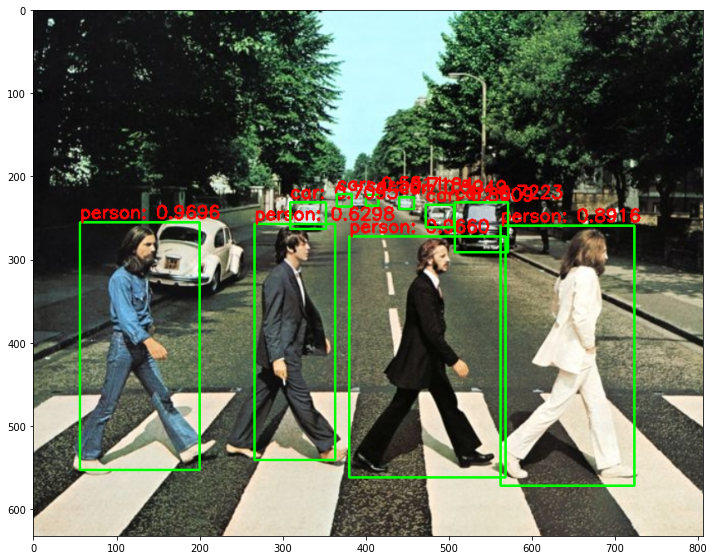

In [6]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('/content/data/beatles01.jpg')

# 원본 이미지 (633, 806)를 네트웍에 입력시에는 (300, 300)로 resize 함. 
# 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0]
cols = img.shape[1]
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img.copy()

# 원본 이미지 배열을 사이즈 (300, 300)으로, BGR을 RGB로 변환하여 배열 입력
cv_net.setInput(cv2.dnn.blobFromImage(img,  size=(300, 300), swapRB=True, crop=False))
# Object Detection 수행하여 결과를 cv_out으로 반환 
cv_out = cv_net.forward()
print(cv_out.shape)

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# detected 된 object들을 iteration 하면서 정보 추출
for detection in cv_out[0,0,:,:]:
    score = float(detection[2])
    class_id = int(detection[1])
    # detected된 object들의 score가 0.4 이상만 추출
    if score > 0.4:
        # detected된 object들은 image 크기가 (300, 300)으로 scale된 기준으로 예측되었으므로 ★다시 원본 이미지 비율로 계산
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
        # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
        caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
        
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 2)
        print(caption, class_id)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### 단일 이미지의 object detection을 함수로 생성

In [7]:
import time

def get_detected_img(cv_net, img_array, score_threshold, is_print=True):
    
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    
    draw_img = img_array.copy()
    
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, size=(300, 300), swapRB=True, crop=False))
    
    start = time.time()
    cv_out = cv_net.forward()
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    # detected 된 object들을 iteration 하면서 정보 추출
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])
        # detected된 object들의 score가 0.4 이상만 추출
        if score > score_threshold:
            # detected된 object들은 image 크기가 (300, 300)으로 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names[class_id], score)

            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 2)
    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")

    return draw_img

Detection 수행시간: 0.33 초


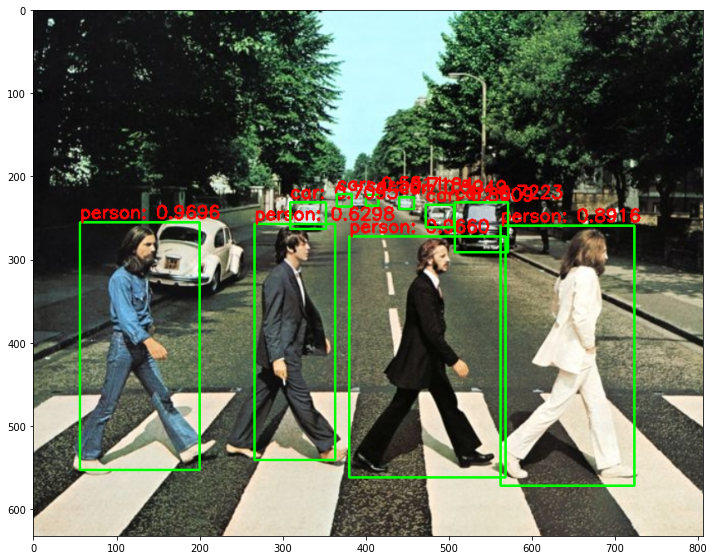

In [8]:
# image 로드 
img = cv2.imread('/content/data/beatles01.jpg')

#coco dataset 클래스명 매핑

# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net, img, score_threshold=0.4, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

--2022-02-14 13:02:46--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76279 (74K) [image/jpeg]
Saving to: ‘./data/baseball01.jpg’

./data/baseball01.j 100%[===================>]  74.49K  --.-KB/s    in 0.01s   

2022-02-14 13:02:46 (5.87 MB/s) - ‘./data/baseball01.jpg’ saved [76279/76279]

Detection 수행시간: 0.35 초


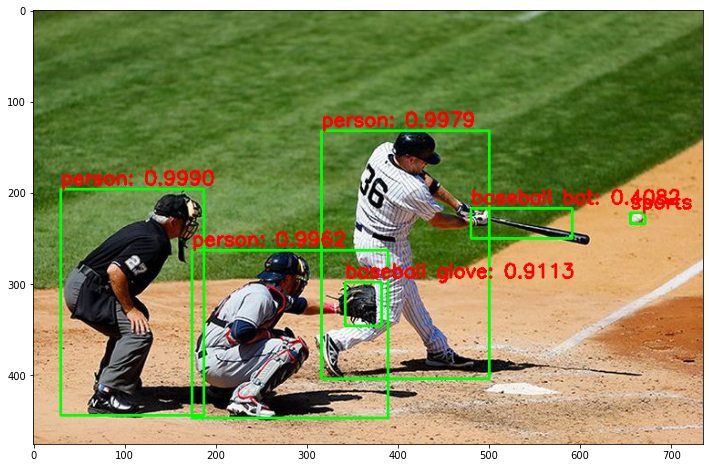

In [9]:
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

img = cv2.imread('/content/data/baseball01.jpg')

#coco dataset 클래스명 매핑

# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net, img, score_threshold=0.4, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

### Video Object Detection 수행

In [10]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2022-02-14 13:03:07--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2022-02-14 13:03:07--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2022-02-14 13:03:07--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.

#### VideoCapture와 VideoWriter 설정하고 Video Detection용 전용 함수 생성
* VideoCapture를 이용하여 Video를 frame별로 capture 할 수 있도록 설정
* VideoCapture의 속성을 이용하여 Video Frame의 크기 및 FPS 설정. 
* VideoWriter를 위한 인코딩 코덱 설정 및 영상 write를 위한 설정
총 Frame 별로 iteration 하면서 Object Detection 수행. 개별 frame별로 단일 이미지 Object Detection과 유사 

In [11]:
def do_detected_video(cv_net, input_path, output_path, score_threshold, is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, )

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        
        returned_frame = get_detected_img(cv_net, img_frame, score_threshold=score_threshold, is_print=True)
        vid_writer.write(returned_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [12]:
do_detected_video(cv_net, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_incept.mp4', 0.2, False)

총 Frame 갯수: 58
Detection 수행시간: 0.36 초
Detection 수행시간: 0.36 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.36 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.36 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.33 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.33 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.3